In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "CMU Sans Serif"
    }
</style>

In [ ]:
!pip install pycalphad

In [16]:
import os
os.environ["REPOSITORY_URL"] = 'https://raw.githubusercontent.com/pyracetamol/tmms_2025/refs/heads/main/pycalphad'

In [ ]:
!wget -O Cr-Fe-Ni.db "$REPOSITORY_URL/Cr-Fe-Ni.tdb"
!wget -O Fe-C.TDB "$REPOSITORY_URL/Fe-C.TDB"

# Introduction to Pycalphad:
This introduction will walk you through the basic steps of using Pycalphad (and python software).
## Opening a Database
Any calculation in pycalphad requires you to define:
* A database
* The components to consider (including 'VA' for vacancies)
* The phases to consider
* The conditions of the calculation

In python you need to import the tools that we use to perform our code. They act as additions to the basic python language. In general you can copy them as you see here without any modification. At the begining of any new session you must run these import statements to get all the tools we need. if the command below exicutes without any errors, your installation of pycalphad is succesfull.

In [4]:
from pycalphad import Database

When using the "Database()" command you can load a database. 
NOTE: the code below works only if your .TDB file is in the same file location as your jupyter notebook. 

In general you can also specify a full file path (ex: E:/Liturature/liturature for Ni database/Al-Co-Cr-Ni/mydb.TDB), this is useful if your file is in a arbitrary folder.

In [15]:
db = Database('Cr-Fe-Ni.tdb')

## Looking at the Contents of Databases
Databases contain lots of information, much of which will help us set up calculations. Some useful things to look at are:
- the elements
- the phases
- the consituents of a particular phase

We can see all of these using the following commands:

In [4]:
# the print() command will output anything that is specified, it can be used with variables and text  
print("The elements contained in this database are:")
print(db.elements)                      #this prints the elements defined in the loaded database

print("The phases contained in this database are:")
print(list(db.phases.keys()))           #this prints the phases

print("The constituents of the SIGMA phase are:")
print(db.phases['SIGMA'].constituents)  #this prints the constituents of a specified phase

The elements contained in this database are:
{'/-', 'NI', 'FE', 'VA', 'CR'}
The phases contained in this database are:
['LIQUID', 'BCC_A2', 'FCC_A1', 'HCP_A3', 'SIGMA']
The constituents of the SIGMA phase are:
(frozenset({Species('FE', 'FE1'), Species('NI', 'NI1')}), frozenset({Species('CR', 'CR1')}), frozenset({Species('CR', 'CR1'), Species('FE', 'FE1'), Species('NI', 'NI1')}))


## Setting Conditions & Running Equilibrium Calculations

In any thermodynamic calculation, you must define $c+2$ conditions for $c$ components. However, in pycalphad, molar quantities are always calculated with the implicit assumption that $n = 1$ (total amount of substance), so you only need to specify $c+1$ conditions.

Each condition—pressure, temperature, and composition—is defined in pycalphad using the `v.` prefix:

- Pressure: `v.P`, in Pascals. Note that many thermodynamic databases do not explicitly model pressure dependence. By convention, standard pressure is 101325 Pa (1 atm).
- Temperature: `v.T`, in Kelvin. Most databases are valid between 298.15 K and 6000 K, so calculations should stay within this range.
- Composition: `v.X('NI')`, specifying the mole fraction of a component (example for Nickel).

---

## The `equilibrium()` and `calculate()` Functions

The two primary functions you will use for thermodynamic calculations in pycalphad are `equilibrium()` and `calculate()`. Both require you to define:

- A thermodynamic database
- A list of components
- A list of phases to consider
- The conditions of the calculation

Optionally, you can specify the output property you'd like to compute. Below is a list of common output keywords:

| Property                      | Keyword              |
|-------------------------------|----------------------|
| Molar Enthalpy                | `'HM'`               |
| Mixing Enthalpy               | `'HM_mix'`           |
| Molar Gibbs Energy            | `'GM'`               |
| Mixing Gibbs Energy           | `'GM_mix'`           |
| Molar Entropy                 | `'SM'`               |
| Heat Capacity                 | `'heat_capacity'`    |
| Degree of Ordering            | `'degree_of_ordering'` or `'DOO'` |
| Molar Heat Capacity           | `'CPM'`              |
| Mixing Heat Capacity          | `'CPM_MIX'`          |
| Excess Mixing Energy          | `'excess_mixing_energy'` |
| Abstract Syntax Tree (debug)  | `'ast'`              |

Use these keywords in your function call to control the thermodynamic quantity that is returned.

In [5]:
from pycalphad import equilibrium
from pycalphad import variables as v

# Define components:
# Note: must have the correct capitialization.
# CALPHAD modelers usually use all-caps by convention.
# Also note that we include VA. Always do this.
components = ['CR', 'VA'] 

# Define the phases:
phases = ['LIQUID', 'BCC_A2', 'FCC_A1']

# And the conditions:
# This is a map of the variable to its value
conditions = {v.P: 101325, v.T: 500}

# do the equilibrium calculation and store the result in the `eq` variable
eq = equilibrium(db, components, phases, conditions)
print(eq)

<xarray.Dataset> Size: 176B
Dimensions:    (N: 1, P: 1, T: 1, vertex: 2, component: 1, internal_dof: 2)
Coordinates:
  * N          (N) float64 8B 1.0
  * P          (P) float64 8B 1.013e+05
  * T          (T) float64 8B 500.0
  * vertex     (vertex) int64 16B 0 1
  * component  (component) <U2 8B 'CR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, vertex) float64 16B 1.0 nan
    GM         (N, P, T) float64 8B -1.316e+04
    MU         (N, P, T, component) float64 8B -1.316e+04
    X          (N, P, T, vertex, component) float64 16B 1.0 nan
    Y          (N, P, T, vertex, internal_dof) float64 32B 1.0 1.0 nan nan
    Phase      (N, P, T, vertex) <U6 48B 'BCC_A2' ''
Attributes:
    engine:   pycalphad 0.11.0
    created:  2025-03-25T16:38:03.676486


## Plotting: $C_p$ vs. Temperature

Plotting is an essential part of analyzing thermodynamic data. With Matplotlib, creating visualizations like plots and graphs is straightforward. In this section, we will briefly walk through calculating the heat capacity $(C_p)$ and plotting the results.

### Importing Libraries

Now that we know how to define variables, let's calculate the heat capacity of cementite. We'll start by importing the necessary Python libraries (tools) required for the calculation and plotting:

- Matplotlib allows us to create plots and visualize data in various ways. It offers a wide range of customization options for figures and graphs.
- NumPy provides mathematical tools and functions that make numerical operations easier and more efficient.

> 📌 *Tip:* It is good practice to place all your `import` statements at the top of your script or notebook for better readability and organization.

In [6]:
# Only needed in a Jupyter Notebook
%matplotlib inline
import matplotlib
# Optional plot styling
matplotlib.style.use('fivethirtyeight')
import matplotlib.pyplot as plt

import numpy as np

from pycalphad import Database, calculate, equilibrium, variables as v, Model

### Calculating

We will use the `calculate()` function from pycalphad. In this example, we calculate the heat capacity of the cementite phase (`CEMENTITE_D011`) in the Fe-C system over a temperature range from 1 K to 2000 K, with a step size of 0.02 K.

In [8]:
result = calculate(Database('Fe-C.TDB'), ['FE', 'C'], 'CEMENTITE', T=(1, 2000, 0.02), output='heat_capacity')

### Plotting
Below is just a small sample of the commands that can be used to plot using matplat lib. There are many other tools that change the appearence of the figures it generates, as well as commands that can save figures as images in various file formats. To learn more about matplot lib go here: https://matplotlib.org/index.html

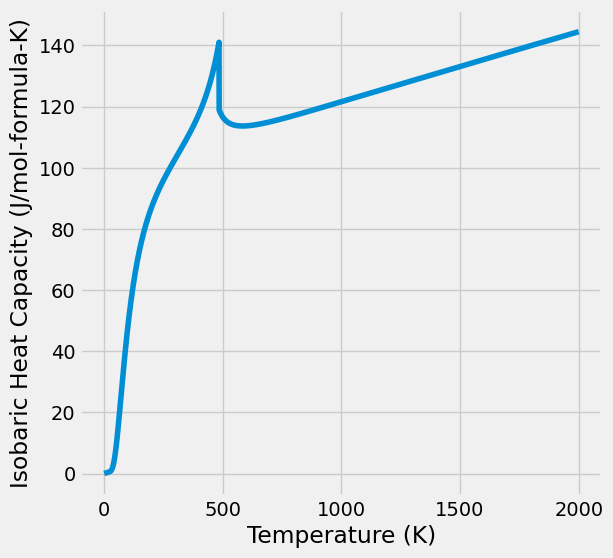

In [9]:
# Note: 4 moles of atoms per formula unit (Fe3C1). That's why we multiply by 4

fig = plt.figure(figsize=(6,6)) # plt is the alias we set for matplotlib 

fig.gca().set_xlabel('Temperature (K)')
fig.gca().set_ylabel('Isobaric Heat Capacity (J/mol-formula-K)')

fig.gca().plot(result['T'], np.squeeze(4.0 * result['heat_capacity']))

plt.show() # this command prints the plot out

# Plotting Phase Diagrams:
## Binary Phase Diagrams
Finally we would like to create phase diagrams from our .TDB files. Luckily this too is a feature in pycalphad. This can be done using the binplot() command. Calculating phase diagrams can be time consuming depending on the number of points in your calculation and may take anywhere between several minutes and several hours. In upcoming versions of the software this speed will likely improve so look for updates. The settings below have been set to run phase diagrams quickly with large step sizes.

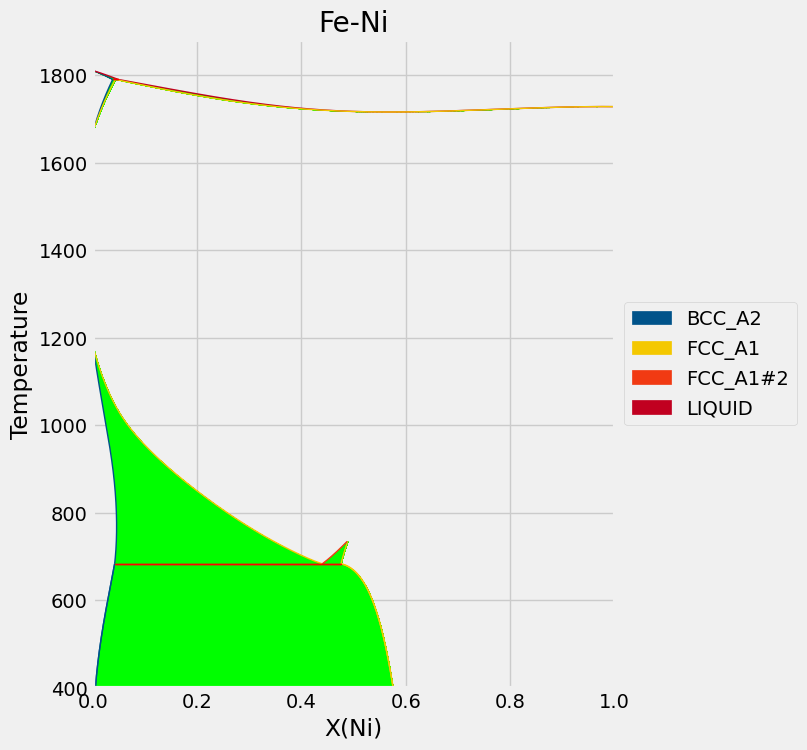

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from pycalphad import Database, binplot
import pycalphad.variables as v

db = Database('Cr-Fe-Ni.tdb')
phases = list(db.phases.keys())

fig = binplot(db, ['NI', 'FE', 'VA'], phases, {v.X('NI'):(0,1,0.01),v.T:(400, 3000, 0.1),v.P:101325}).get_figure()
plt.grid()
fig.set_size_inches(6,8)